In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Embedding
from keras.layers import GRU, Input, LSTM, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import random

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# some parts written with the help of the following link:
# https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639

input = []
target = []

filename='/content/drive/MyDrive/ferdousi.txt'
with open(filename, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
i = 0
for line in lines:
  if i > 1:
    if (i % 2) == 0:
      input.append(line)
    if (i % 2) == 1:
      target_text = "<BOS> " + line + " <EOS>"
      target.append(target_text)
  i=i+1

input = input[:-1]  # input and target most be the same size

max_encoder_seq_length = max([len(txt.split()) for txt in input], default=0)
max_decoder_seq_length = max([len(txt.split()) for txt in target], default=0)
print("encoder max number of words: " + str(max_encoder_seq_length))
print("decoder max number of words: " + str(max_decoder_seq_length))


encoder max number of words: 11
decoder max number of words: 13


In [6]:
vocab_size = 2000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(input+target)
dictionary = tokenizer.word_index
random_words = dict(random.sample(dictionary.items(), 10))
print("20 random samples of vaocabulary:")
print(random_words)
print('\n')
encoder_sequences = tokenizer.texts_to_sequences(input)
decoder_sequences = tokenizer.texts_to_sequences(target)

print("input samples and ids:")
print(input[0:5])
print(encoder_sequences[0:5])
print('\n')

print("target samples and ids:")
print(target[0:5])
print(encoder_sequences[0:5])
print('\n')

encoder_input_data = pad_sequences(encoder_sequences, maxlen=max_encoder_seq_length, dtype='int32', padding='post', truncating='post')
decoder_input_data = pad_sequences(decoder_sequences, maxlen=max_decoder_seq_length, dtype='int32', padding='post', truncating='post')

print("5 smaples padded sentences:")
print(encoder_input_data[:5])
print(decoder_input_data[:5])

20 random samples of vaocabulary:
{'گزینی': 5225, 'ببرید': 1551, 'ایدنک': 11081, 'برافگند': 1280, 'غلامان': 3604, 'جسته': 3943, 'شاهشان': 4135, 'توتنهاشدی': 17582, 'بگویند': 3547, 'نستوده': 15703}


input samples and ids:
['به نام خداوند جان و خرد', 'خداوند نام و خداوند جای', 'خداوند کیوان و گردان سپهر', 'ز نام و نشان و گمان برترست', 'به بینندگان آفریننده را']
[[4, 82, 364, 118, 3, 100], [364, 82, 3, 364, 60], [364, 1186, 3, 158, 264], [6, 82, 3, 381, 3, 498], [4, 9]]


target samples and ids:
['<BOS> کزین برتر اندیشه برنگذرد <EOS>', '<BOS> خداوند روزی ده رهنمای <EOS>', '<BOS> فروزنده ماه و ناهید و مهر <EOS>', '<BOS> نگارندهٔ بر شده پیکرست <EOS>', '<BOS> نبینی مرنجان دو بیننده را <EOS>']
[[4, 82, 364, 118, 3, 100], [364, 82, 3, 364, 60], [364, 1186, 3, 158, 264], [6, 82, 3, 381, 3, 498], [4, 9]]


5 smaples padded sentences:
[[   4   82  364  118    3  100    0    0    0    0    0]
 [ 364   82    3  364   60    0    0    0    0    0    0]
 [ 364 1186    3  158  264    0    0    0    0 

In [7]:
decoder_output_data = np.zeros((len(input), max_decoder_seq_length, vocab_size), dtype="int32")
for i, seqs in enumerate(decoder_input_data):
      for j, seq in enumerate(seqs):
          if j > 0:
              decoder_output_data[i][j][seq] = 1.
print(decoder_output_data.shape)

print(decoder_output_data[:5])

(49608, 13, 2000)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]]]


In [8]:
latent_dim = 256

encoder_inputs = Input(shape=(max_encoder_seq_length, ), dtype='int32',)
encoder_embedding = Embedding(input_dim = vocab_size, 
                          output_dim = latent_dim)(encoder_inputs)
encoder_LSTM = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

decoder_inputs = Input(shape=(max_decoder_seq_length, ), dtype='int32',)
decoder_embedding = Embedding(input_dim = vocab_size, 
                          output_dim = latent_dim)(decoder_inputs)
decoder_LSTM = LSTM(latent_dim, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])

decoder_dense = keras.layers.Dense(vocab_size, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)
model_lstm = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model_lstm.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 11, 256)      512000      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 13, 256)      512000      ['input_2[0][0]']                
                                                                                              

Epoch 1/5
397/397 [==============================] - 16s 23ms/step - loss: 2.2623 - accuracy: 0.6479 - val_loss: 1.2794 - val_accuracy: 0.8020
Epoch 2/5
397/397 [==============================] - 8s 21ms/step - loss: 0.7700 - accuracy: 0.8924 - val_loss: 0.3538 - val_accuracy: 0.9591
Epoch 3/5
397/397 [==============================] - 9s 22ms/step - loss: 0.1821 - accuracy: 0.9836 - val_loss: 0.0787 - val_accuracy: 0.9955
Epoch 4/5
397/397 [==============================] - 8s 21ms/step - loss: 0.0313 - accuracy: 0.9992 - val_loss: 0.0182 - val_accuracy: 0.9993
Epoch 5/5
397/397 [==============================] - 8s 20ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 0.9995


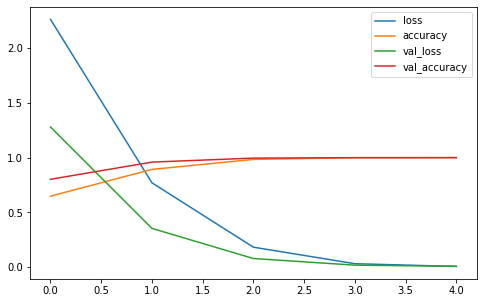

In [9]:
model_lstm.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history = model_lstm.fit(
    [encoder_input_data, decoder_input_data],
    decoder_output_data,
    batch_size=100,
    epochs=5,
    validation_split=0.2,
)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()


In [10]:
latent_dim = 256

encoder_inputs = Input(shape=(max_encoder_seq_length, ), dtype='int32',)
encoder_embedding = Embedding(input_dim = vocab_size, 
                          output_dim = latent_dim)(encoder_inputs)
encoder_GRU = GRU(latent_dim, return_state=True)
encoder_outputs, state_h = encoder_GRU(encoder_embedding)

decoder_inputs = Input(shape=(max_decoder_seq_length, ), dtype='int32',)
decoder_embedding = Embedding(input_dim = vocab_size, 
                          output_dim = latent_dim)(decoder_inputs)
decoder_GRU = GRU(latent_dim, return_state=True, return_sequences=True)
decoder_outputs, _ = decoder_GRU(decoder_embedding, initial_state=state_h)

decoder_dense = keras.layers.Dense(vocab_size, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)
model_gru = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model_gru.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history = model_gru.fit(
    [encoder_input_data, decoder_input_data],
    decoder_output_data,
    batch_size=100,
    epochs=5,
    validation_split=0.2,
)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/5
397/397 [==============================] - 12s 22ms/step - loss: 1.9376 - accuracy: 0.7201 - val_loss: 0.4972 - val_accuracy: 0.9387
Epoch 2/5
397/397 [==============================] - 8s 20ms/step - loss: 0.1562 - accuracy: 0.9854 - val_loss: 0.0291 - val_accuracy: 0.9987
Epoch 3/5
397/397 [==============================] - 8s 20ms/step - loss: 0.0088 - accuracy: 0.9999 - val_loss: 0.0095 - val_accuracy: 0.9994
Epoch 4/5
266/397 [===================>..........] - ETA: 2s - loss: 0.0032 - accuracy: 1.0000